In [1]:
from math import ceil
from time import sleep
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor, as_completed

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)

import pandas as pd
import networkx as nx

import requests
from json import JSONDecodeError

## Part 2 Network Analysis in Computational Social Science

These exercises are taken from Week 6: __Exercise 1: Mixing Patterns and Assortativity__ and __Exercise 3: Zachary's karate club__.

> __Exercise 1: Mixing Patterns and Assortativity__
>
> __Part 1: Assortativity Coefficient__
> 1. *Calculate the Assortativity Coefficient* for the network based on the country of each node. Implement the calculation using the formula provided during the lecture, also available in [this paper](https://arxiv.org/pdf/cond-mat/0209450.pdf) (equation 2, here for directed networks). **Do not use the NetworkX implementation.**

We start by loading in the network from the edge list:

In [2]:
net_path = 'data/author_edgelist.csv'
net = pd.read_csv(net_path)
net

,author_1,author_2,weight
0,https://openalex.org/A5010373001,https://openalex.org/A5072156055,1
1,https://openalex.org/A5032475130,https://openalex.org/A5072156055,1
2,https://openalex.org/A5010373001,https://openalex.org/A5032475130,1
3,https://openalex.org/A5054630728,https://openalex.org/A5072156055,2
4,https://openalex.org/A5005839111,https://openalex.org/A5072156055,4
...,...,...,...
46178,https://openalex.org/A5067122850,https://openalex.org/A5090329397,1
46179,https://openalex.org/A5088656844,https://openalex.org/A5090329397,1
46180,https://openalex.org/A5067122850,https://openalex.org/A5088656844,1
46181,https://openalex.org/A5067122850,https://openalex.org/A5103326255,1


Now we want to make a lookup table to get the country code for each author. To do this, we need to request information from openalex, and the fastest way to do this is to batch the authors in groups of maximum 25 authors and thread the requests.

First we find all the uniqe authors and batch them up:

In [3]:
# Concatenate the authors and remove duplicates
all_authors = pd.concat([net['author_1'], net['author_2']]).unique().astype(str)

all_authors_id = np.empty(len(all_authors), dtype=object)
for i, author in enumerate(all_authors):
    all_authors_id[i] = author[21:] # romves the 'https://openalex.org/'

author_batches = np.array_split(all_authors_id, ceil(len(all_authors_id) / 25))

# Columns in the lookup table
cols = ['id', 'display_name', 'works_api_url', 'works_count', 'country_code', 'h_index']
source = 'https://api.openalex.org/authors'

print('Number of batches:', len(author_batches))
print('All authors:')
all_authors

Number of batches: 567
All authors:


array(['https://openalex.org/A5010373001',
       'https://openalex.org/A5032475130',
       'https://openalex.org/A5054630728', ...,
       'https://openalex.org/A5100727437',
       'https://openalex.org/A5100709554',
       'https://openalex.org/A5109934253'], shape=(14158,), dtype='<U32')

In [4]:
# Get request data from 1 author
def get_result(result_author: dict) -> list[int | str | None]:
    """
    Processes the result data from a single author
    :param result_author: Result dictionary from 'https://api.openalex.org/authors'
    :return: A list of values corresponding to [id, display_name, works_api_url, works_count, country_code, h_index]
    """
    last_known_institution = result_author.get('last_known_institutions', [])
    summary_stats = result_author.get('summary_stats', {})

    # Build the data row
    local_data = [result_author.get('id', None), result_author.get('display_name', None),
                  result_author.get('works_api_url', None), result_author.get('works_count', None)]
    try:
        country_code = last_known_institution[0]['country_code']
        local_data.append(country_code)
    except (IndexError, KeyError):
        local_data.append(None)
    local_data.append(summary_stats.get('h_index', None))

    return local_data


def process_author(author_batch, batch_index) -> list[list[int | str | None]]:
    """
    Process a batch of authors by making a request session and calling the API with retry logic.
    :param author_batch: List of author ids corresponding to the batch of authors. Max of 25 authors in the list!
    :param batch_index: Batch index
    :return: A list of values corresponding to [id, display_name, works_api_url, works_count]
    """
    local_session = requests.Session()

    tries = 0
    while tries < 10:
        try:
            author_ids_str = '|'.join(author_batch)
            url = (
                f'{source}?filter=id:{author_ids_str}?'
            )
            response = local_session.get(url, params={'per_page':200})
            local_results = response.json()['results']
            break  # Exit the retry loop on success
        except (JSONDecodeError, requests.exceptions.RequestException):
            tries += 1
            sleep(0.1)
    else:
        raise f'Skipping batch index {batch_index}, too many tries'

    # Collect all data into one list
    local_data = []
    for local_result in local_results:
        local_result = get_result(local_result)
        local_data.append(local_result)

    return local_data

In [5]:
results_list = []

with ThreadPoolExecutor(max_workers=10) as executor:
    # Map each batch to a future
    future_to_author = {executor.submit(process_author, batch, idx): idx for idx, batch in enumerate(author_batches)}

    for future in tqdm(as_completed(future_to_author), total=len(author_batches)):
        batch_idx = future_to_author[future]
        try:
            results = future.result()
            # Flatten the results:
            for result in results:
                results_list.append(result)
        except Exception as exc:
            print(f"Exception for batch {batch_idx}: {exc}")

# Combine the results into a DataFrame
lookup_table = pd.DataFrame(results_list, columns=cols)
lookup_table

100%|██████████| 567/567 [01:03<00:00,  8.87it/s]


,id,display_name,works_api_url,works_count,country_code,h_index
0,https://openalex.org/A5032448943,Paul T. Seed,https://api.openalex.org/works?filter=author.i...,751,GB,90
1,https://openalex.org/A5043911021,Reinhard Busse,https://api.openalex.org/works?filter=author.i...,653,DE,76
2,https://openalex.org/A5060850927,Christine Bond,https://api.openalex.org/works?filter=author.i...,415,GB,50
3,https://openalex.org/A5046292035,Paul McNamee,https://api.openalex.org/works?filter=author.i...,388,IT,54
4,https://openalex.org/A5058962672,Job van Exel,https://api.openalex.org/works?filter=author.i...,374,NL,60
...,...,...,...,...,...,...
14153,https://openalex.org/A5100709563,Meng Wang,https://api.openalex.org/works?filter=author.i...,21,CN,7
14154,https://openalex.org/A5108671287,Patrick Le Callet,https://api.openalex.org/works?filter=author.i...,15,FR,4
14155,https://openalex.org/A5101631518,Zeyuan Chen,https://api.openalex.org/works?filter=author.i...,14,CN,6
14156,https://openalex.org/A5100772309,Lei Zhang,https://api.openalex.org/works?filter=author.i...,11,CN,6


Now that we have the lookup table, we can now save it and use it for calculating the Assortativity Coefficient.

In [6]:
lookup_table_path = 'data/author_edgelist_lookup_table.csv'

In [7]:
lookup_table.to_csv(lookup_table_path)

In [8]:
look_up_table = pd.read_csv(lookup_table_path)
look_up_table

,Unnamed: 0,id,display_name,works_api_url,works_count,country_code,h_index
0,0,https://openalex.org/A5032448943,Paul T. Seed,https://api.openalex.org/works?filter=author.i...,751,GB,90
1,1,https://openalex.org/A5043911021,Reinhard Busse,https://api.openalex.org/works?filter=author.i...,653,DE,76
2,2,https://openalex.org/A5060850927,Christine Bond,https://api.openalex.org/works?filter=author.i...,415,GB,50
3,3,https://openalex.org/A5046292035,Paul McNamee,https://api.openalex.org/works?filter=author.i...,388,IT,54
4,4,https://openalex.org/A5058962672,Job van Exel,https://api.openalex.org/works?filter=author.i...,374,NL,60
...,...,...,...,...,...,...,...
14153,14153,https://openalex.org/A5100709563,Meng Wang,https://api.openalex.org/works?filter=author.i...,21,CN,7
14154,14154,https://openalex.org/A5108671287,Patrick Le Callet,https://api.openalex.org/works?filter=author.i...,15,FR,4
14155,14155,https://openalex.org/A5101631518,Zeyuan Chen,https://api.openalex.org/works?filter=author.i...,14,CN,6
14156,14156,https://openalex.org/A5100772309,Lei Zhang,https://api.openalex.org/works?filter=author.i...,11,CN,6


We can now calculate the Assortativity Coefficient:

In [9]:
# Construct id lookup table
id_to_country = dict(zip(look_up_table['id'], look_up_table['country_code']))
id_to_country

{'https://openalex.org/A5032448943': 'GB',
 'https://openalex.org/A5043911021': 'DE',
 'https://openalex.org/A5060850927': 'GB',
 'https://openalex.org/A5046292035': 'IT',
 'https://openalex.org/A5058962672': 'NL',
 'https://openalex.org/A5103205115': 'GB',
 'https://openalex.org/A5035329084': 'GB',
 'https://openalex.org/A5009999606': 'GB',
 'https://openalex.org/A5077924811': 'GB',
 'https://openalex.org/A5009842882': 'GB',
 'https://openalex.org/A5030806697': 'GB',
 'https://openalex.org/A5050702492': 'GB',
 'https://openalex.org/A5007560752': 'GB',
 'https://openalex.org/A5046456153': 'NL',
 'https://openalex.org/A5013501141': 'GB',
 'https://openalex.org/A5007822070': 'GB',
 'https://openalex.org/A5055445056': 'GB',
 'https://openalex.org/A5067498065': 'GB',
 'https://openalex.org/A5028041567': 'GB',
 'https://openalex.org/A5014987797': 'GB',
 'https://openalex.org/A5000933035': 'GB',
 'https://openalex.org/A5052842430': 'GB',
 'https://openalex.org/A5002640829': 'GB',
 'https://o

In [10]:
def calculate_r(df: pd.DataFrame) -> float:
    # Initialize defaultdicts (because they start with a value of 0)
    e_uu = defaultdict(int)
    a_uu = defaultdict(int)

    e_len = 0
    a_len = 0

    # Vectorized access to DataFrame values
    author_1 = df["author_1"].values
    author_2 = df["author_2"].values

    # Lookup country codes using the id dictionary
    country_codes_1 = [id_to_country.get(a) for a in author_1]
    country_codes_2 = [id_to_country.get(a) for a in author_2]

    # Count occurrences in a_uu and count edge occurrences in e_uu
    for c1, c2 in zip(country_codes_1, country_codes_2):
        # update a
        a_uu[c1] += 1
        a_uu[c2] += 1
        a_len += 2

        # update e
        e_len += 1
        if c1 == c2:
            e_uu[c1] += 1

    # Normalize by length
    e_uu_processed = np.array( list( e_uu.values() ) ) / e_len
    a_uu_processed = np.array( list( a_uu.values() ) ) / a_len

    # Sum them up
    e_sum = np.sum(e_uu_processed)
    a_sum = np.sum(np.dot(a_uu_processed, a_uu_processed))

    # Calcualte Assortativity Coefficient r
    r = (e_sum - a_sum) / (1 - a_sum)

    return r

In [11]:
r_net = calculate_r(net)
r_net

np.float64(0.4120306275729761)

Since the Assortativity Coefficient is moderately positive, it suggests that authors from the same country tend to collaborate more often.

> __Part 2: Configuration model__
> In the following, we are going to assess the significance of the assortativity by comparing the network's assortativity coefficient against that of random networks generated through the configuration model.
>
> 2. *Implement the configuration model* using the _double edge swap_ algorithm to generate random networks. Ensure each node retains its original degree but with altered connections. Create a function that does that by following these steps:
>   - **a.** Create an exact copy of your original network.
>   - **b.** Select two edges, $e_{1} = (u,v)$ and $e_{2} = (x,y)$, ensuring *u != y* and *v != x*.
>   - **c.** Flip the direction of $e_{1}$ to $e_{1} = (v,u)$ 50% of the time. This ensure that your final results is not biased, in case your edges were sorted (they usually are).
>   - **d.** Ensure that new edges $e_{1}' = (e_{1}[0],e_{2}[1])$ and $e_{2}' = (e_{2}[0],e_{1}[1])$ do not already exist in the network.
>   - **e.** Remove edges $e_{1}$ and $e_{2}$ and add edges $e_{1}'$ and $e_{2}'$.
>   - **f.** Repeat steps **b** to **e** until you have performed _E*10_ swaps, where E is the total number of edges.
> 3. *Double check that your algorithm works well*, by showing that the degree of nodes in the original network and the new 'randomized' version of the network are the same.

In [12]:
def configuration_model(df: pd.DataFrame) -> pd.DataFrame:
    #  a.
    df = df.copy()
    # Shuffle DataFrame
    df = df.sample(frac=1).reset_index(drop=True)

    author_1 = df["author_1"].values.copy()
    author_2 = df["author_2"].values.copy()

    n = len(df)
    n_pairs = n // 2
    # even indices: first row in each pair
    idx = np.arange(0, n_pairs * 2, 2)

    #  b.
    # Extract pairs for rows i and i+1.
    e1_author1 = author_1[idx].copy()
    e1_author2 = author_2[idx].copy()
    e2_author1 = author_1[idx + 1].copy()
    e2_author2 = author_2[idx + 1].copy()

    #  c.
    # Generate a random swap mask with a 50% chance of swapping
    swap_mask = np.random.rand(n_pairs) >= 0.5

    # For pairs that need swapping, swap the two elements of e1.
    temp_e1_author1 = e1_author1.copy()
    temp_e1_author2 = e1_author2.copy()
    e1_author1[swap_mask] = temp_e1_author2[swap_mask]
    e1_author2[swap_mask] = temp_e1_author1[swap_mask]

    #  d.
    # Reconstruct new pairs exactly as in the loop:
    new_e1_author1 = e1_author1      # first element for row i
    new_e1_author2 = e2_author2      # second element for row i
    new_e2_author1 = e2_author1      # first element for row i+1
    new_e2_author2 = e1_author2      # second element for row i+1

    # Write the new values back into the full arrays.
    author_1[idx] = new_e1_author1
    author_2[idx] = new_e1_author2
    author_1[idx + 1] = new_e2_author1
    author_2[idx + 1] = new_e2_author2

    #  e.
    # Update the DataFrame.
    df["author_1"] = author_1
    df["author_2"] = author_2

    return df

In [13]:
random_net = net.copy()
#  f.
for N in range(10):
    random_net = configuration_model(random_net)

random_net

,author_1,author_2,weight
0,https://openalex.org/A5100435670,https://openalex.org/A5026631837,1
1,https://openalex.org/A5055485246,https://openalex.org/A5101568942,1
2,https://openalex.org/A5014155582,https://openalex.org/A5031538551,1
3,https://openalex.org/A5035332763,https://openalex.org/A5023383528,1
4,https://openalex.org/A5025029489,https://openalex.org/A5088335376,1
...,...,...,...
46178,https://openalex.org/A5005448339,https://openalex.org/A5058154612,1
46179,https://openalex.org/A5053642846,https://openalex.org/A5030262115,1
46180,https://openalex.org/A5015442985,https://openalex.org/A5065691898,2
46181,https://openalex.org/A5090183461,https://openalex.org/A5040468715,18


We can see that the new random network has the same number of rows, which also means that they have the same degree.

We can now look at the r value and see that it should be close to 0:

In [14]:
r_random_net = calculate_r(random_net)
r_random_net

np.float64(0.0028238864051947647)

> __Part 3: Analyzing Assortativity in Random Networks__
>
> 4. *Generate and analyze at least 100 random networks* using the configuration model. For each, calculate the assortativity with respect to the country and plot the distribution of these values. Compare the results with the assortativity of your original network to determine if connections within the same country are significantly higher than chance.

In [15]:
random_models_r = np.empty(100, dtype=object)
for N in tqdm(range(100)):
    random_net = net.copy()

    for M in range(10):
        random_net = configuration_model(random_net)

    random_models_r[N] = calculate_r(random_net)

100%|██████████| 100/100 [00:09<00:00, 10.45it/s]


In [16]:
conf = 1.96 * np.std(random_models_r)/np.sqrt(len(random_models_r))

CI_high = np.mean(random_models_r) + conf
CI_high, conf

(np.float64(-3.7578783878373966e-05), np.float64(0.0002675595784329784))

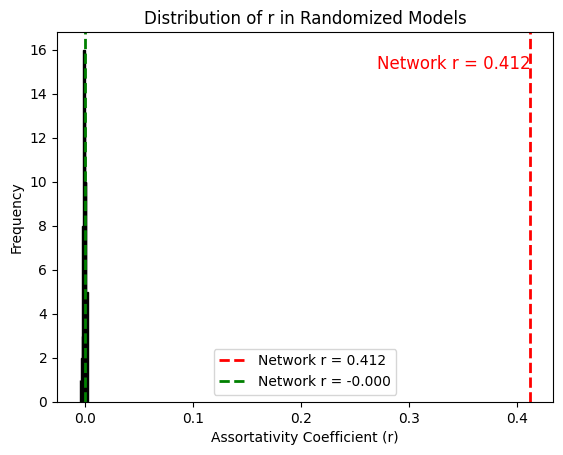

In [17]:
plt.hist(random_models_r, bins=15, edgecolor="black")

# Add vertical line for the none random network value
plt.axvline(r_net, color='red', linestyle='dashed', linewidth=2, label=f'Network r = {r_net:.3f}')

# Add vertical line for the none random network value
plt.axvline(CI_high, color='green', linestyle='dashed', linewidth=2, label=f'Network r = {CI_high:.3f}')

# Annotate the true value
plt.text(r_net, plt.ylim()[1] * 0.9, f'Network r = {r_net:.3f}', color='red', ha='right', fontsize=12)

# Labels
plt.xlabel("Assortativity Coefficient (r)")
plt.ylabel("Frequency")
plt.title("Distribution of r in Randomized Models")
plt.legend()

We can say with very high confidence that the original networks dosen't have completely random connections within different countries.

> __Exercise 2: Zachary's karate club__: In this exercise, we will work on Zarachy's karate club graph (refer to the Introduction of Chapter 9). The dataset is available in NetworkX, by calling the function [karate_club_graph](https://networkx.org/documentation/stable//auto_examples/graph/plot_karate_club.html)
>
> 1. Visualize the graph. Set the color of each node based on the club split (the information is stored as a node attribute). My version of the visualization is below.

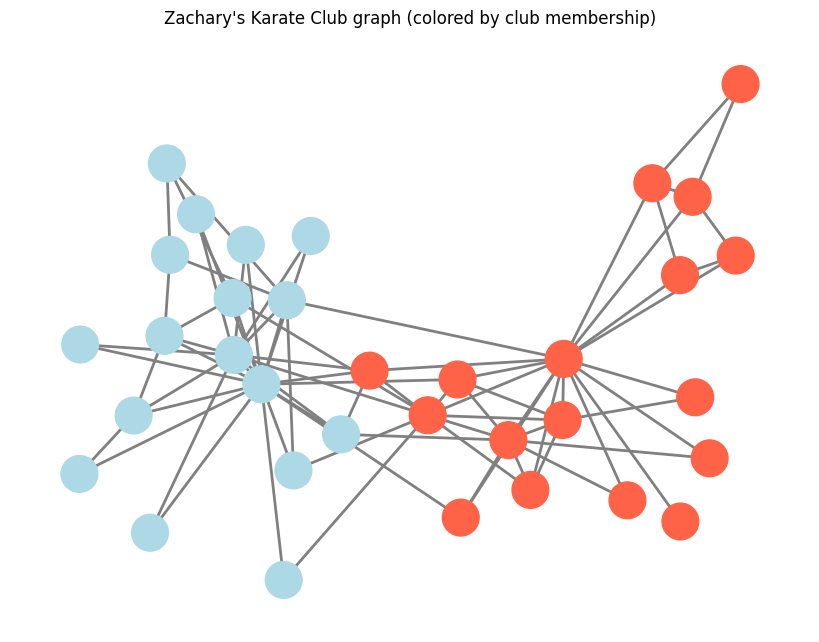

In [43]:
clubs = {'Mr. Hi': 'tomato', 'Officer': 'lightblue'}
G = nx.karate_club_graph()

node_colors = [clubs[G.nodes[node]['club']] for node in G.nodes]

plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=False, node_color=node_colors, edge_color="gray", node_size=700, font_size=10, width=2)

plt.title("Zachary's Karate Club graph (colored by club membership)")
plt.show()


> 2. Write a function to compute the __modularity__ of a graph partitioning (use **equation 9.12** in the book). The function should take a networkX Graph and a partitioning as inputs and return the modularity.

In [44]:
from collections import defaultdict

def modularity(G, node_community):
    L = G.number_of_edges()

    # Compute L_c (intra-community edges) and k_c (degree sum per community)
    club_links = defaultdict(int)
    degrees = defaultdict(int)

    for u, v in G.edges():
        if node_community[u] == node_community[v]:  # Same club
            club_links[node_community[u]] += 1
        degrees[u] += 1
        degrees[v] += 1

    club_total_degrees = defaultdict(int)
    for i in range(len(degrees.values())):
        club_total_degrees[node_community[i]] += degrees[i]
            
    # Compute and return modularity using the equation from the book
    return sum((Lc / L) - (kc / (2 * L))**2 for Lc, kc in zip(club_links.values(), club_total_degrees.values()))

> 3. Explain in your own words the concept of _modularity_.

The modularity explains the quality if the partition of groups in the graph corresponds with the communities. If the modularity is high as high as possible the partition is optimal. If the modularity is 0 we may have only one community. If we have negative modularity the number of communities might approach the number of nodes in the network.

> 4. Compute the modularity of the Karate club split partitioning using the function you just wrote. Note: the Karate club split partitioning is avilable as a [node attribute](https://networkx.org/documentation/networkx-1.10/reference/generated/networkx.classes.function.get_node_attributes.html), called _"club"_.

In [ ]:
modularity(G, node_colors)

0.3582347140039447

> 5. Create $1000$ randomized version of the Karate Club network using the _double edge swap_ algorithm you wrote in the exercise above 5. For each of them, compute the modularity of the "club" split and store it in a list.

In [50]:
import random

def edge_swap(G, num_swaps):
    F = G.copy()
    edges = list(F.edges())
    
    for _ in range(num_swaps):
        edge1, edge2 = random.sample(edges, 2)

        if edge1[0] != edge2[1] and edge1[1] != edge2[0] and \
           (edge1[0], edge2[1]) not in F.edges() and (edge1[1], edge2[0]) not in F.edges():
            
            if np.random.choice([0, 1]) == 1: # Not Correct. 
                
                F.remove_edge(*edge1)
                F.remove_edge(*edge2)
                new_edge1 = (edge1[0], edge2[1])
                new_edge2 = (edge1[1], edge2[0])
                F.add_edge(*new_edge1)
                F.add_edge(*new_edge2)

                # Updates
                edges.remove(edge1)
                edges.remove(edge2)
                edges.append(new_edge1)
                edges.append(new_edge2)
    
    return F

modularities = []
swaps = G.number_of_edges()
for _ in tqdm(range(1000)):
    F = edge_swap(G,swaps)
    modularities.append(modularity(F,node_colors))

modularities[:10]

100%|██████████| 1000/1000 [00:00<00:00, 1662.05it/s]


[0.17874753451676526,
 0.20438856015779086,
 0.23002958579881652,
 0.17874753451676526,
 0.20438856015779086,
 0.1531065088757396,
 0.17874753451676526,
 0.17874753451676526,
 0.1531065088757396,
 0.17874753451676526]

> 6. Compute the average and standard deviation of the modularity for the random network.

In [51]:
average_modularity = np.mean(modularities)
std_modularity = np.std(modularities)

print(f"Average Modularity: {average_modularity}")
print(f"Standard Deviation: {std_modularity}")

Average Modularity: 0.17815779092702166
Standard Deviation: 0.044073268445317185


> 7. Plot the distribution of the "random" modularity. Plot the actual modularity of the club split as a vertical line (use [axvline](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.axvline.html)).

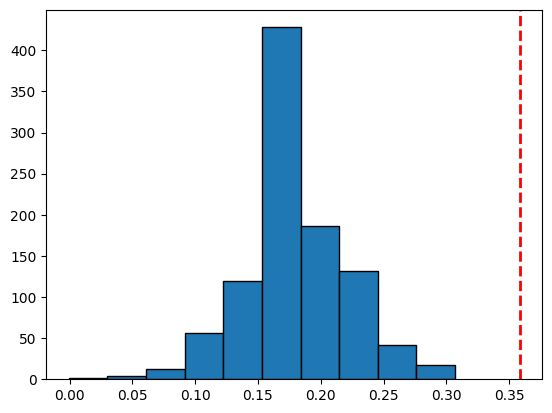

In [56]:
plt.hist(modularities, bins=10, edgecolor="black")
#plot vertical line for the actual modularity
plt.axvline(modularity(G, node_colors), color='red', linestyle='dashed', linewidth=2, label=f'Network Modularity = {modularity(G, node_colors):.3f}')

plt.show()

> 8. Comment on the figure. Is the club split a good partitioning? Why do you think I asked you to perform a randomization experiment? What is the reason why we preserved the nodes degree?

> 9.  Use [the Python Louvain-algorithm implementation](https://anaconda.org/auto/python-louvain) to find communities in this graph. Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the club split? What does this comparison reveal?

> 10.  Compare the communities found by the Louvain algorithm with the club split partitioning by creating a matrix **_D_** with dimension (2 times _A_), where _A_ is the number of communities found by Louvain. We set entry _D_(_i_,_j_) to be the number of nodes that community _i_ has in common with group split _j_. The matrix **_D_** is what we call a [**confusion matrix**](https://en.wikipedia.org/wiki/Confusion_matrix). Use the confusion matrix to explain how well the communities you've detected correspond to the club split partitioning.

In [19]:
G = nx.Graph()

# Add edges from the net DataFrame
for _, row in net.iterrows():
    id_1 = row["author_1"]
    id_2 = row["author_2"]

    # Lookup country codes
    country_1 = str(id_to_country.get(id_1, "Unknown"))
    country_2 = str(id_to_country.get(id_2, "Unknown"))
    # Add nodes with country attributes
    G.add_node(id_1, country=country_1)
    G.add_node(id_2, country=country_2)

    # Add edge
    G.add_edge(id_1, id_2)


r_check = nx.attribute_assortativity_coefficient(G, 'country')
print(r_check)

0.41325214227170065
